In [1]:
%pip install tensorflow numpy matplotlib pandas scikit-learn seaborn


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [216]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import Model, Input, layers, losses, activations, ops
from sklearn.model_selection import train_test_split

In [270]:
import json
import glob

hr_data = []

for json_file in glob.glob('rawhr/*.json'):

    with open(json_file, 'r') as file:
        data = json.load(file)
    
        hr = list(map(lambda x: x[1], data['heartRateValues']))

        if len(hr) != 720:
            print(json_file.name )
        hr_data.append(hr)

hr_data = hr_data + hr_data + hr_data +  hr_data + hr_data + hr_data
hr_data = hr_data + hr_data + hr_data +  hr_data + hr_data + hr_data
hr_data = hr_data + hr_data + hr_data +  hr_data + hr_data + hr_data
hr_data = np.array(hr_data)
print(hr_data.shape)

(4752, 720)


In [218]:
def plot_hr(data):
    plt.figure(figsize=(18, 4))
    plt.plot(data)
    plt.ylim(0,200)
    plt.show()

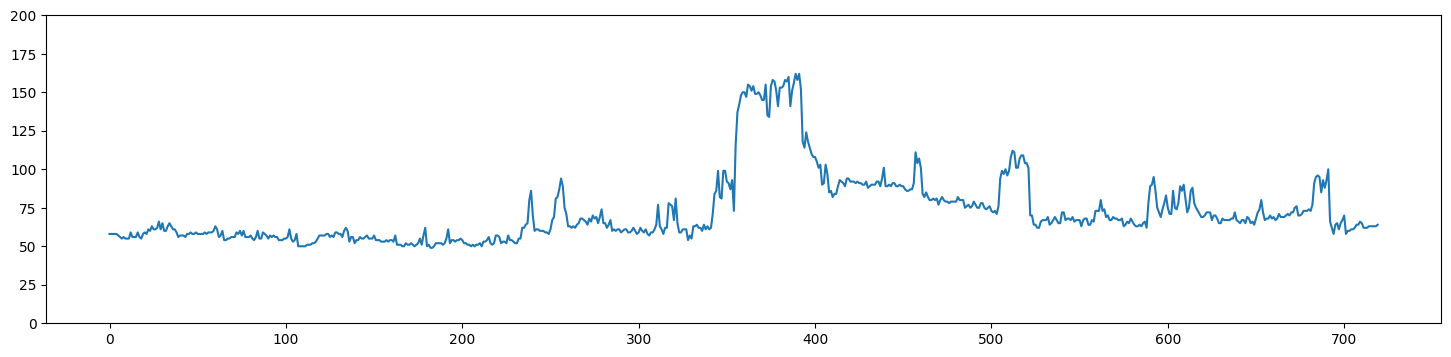

In [28]:
plot_hr(hr_data[2])

In [271]:
x_train = hr_data.astype('float32') / 250.0

x_train_normal, x_val_normal  = train_test_split(x_train, test_size=0.25, random_state=42, shuffle=True)

print(x_train.shape, x_train_normal.shape, x_val_normal.shape)

(4752, 720) (3564, 720) (1188, 720)


In [272]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon

In [273]:
Dense = layers.Dense

latent_dim = 24

def build_autoencoder(input_dim):
    input_encoder = Input(shape=(input_dim,))

    # Encoder
    x = Dense(720,"leaky_relu")(input_encoder)
    x = Dense(360,"leaky_relu" )(x)
    x = Dense(120,"leaky_relu")(x)

    z_mu = Dense(latent_dim, name='latent_mu')(x)
    z_log_var = Dense(latent_dim, name='latent_logvar')(x)
    z = Sampling()([z_mu, z_log_var])

    encoder = Model(inputs=input_encoder, outputs=[z_mu, z_log_var, z], name='encoder')
    encoder.summary()

    #decoder
    input_decoder = Input(shape=(latent_dim,), name='decoder_input')
    x = Dense(120,"leaky_relu")(input_decoder)
    x = Dense(360,"leaky_relu")(x)
    x = Dense(720,"leaky_relu")(x)
    dec = Dense(input_dim, activation='linear')(x)    
    decoder = Model(inputs=input_decoder, outputs=dec, name='decoder_CNN')
    decoder.summary()
    
    vae_outputs = decoder(encoder(input_encoder)[2])
    vae = Model(input_encoder, vae_outputs, name='vae')
    vae.summary()
    return vae

In [274]:
# Build the autoencoder model
input_shape = 720
autoencoder = build_autoencoder(input_shape)

# Compile the model
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_32      │ (None, 720)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_150 (Dense)   │ (None, 720)       │    519,120 │ input_layer_32[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_151 (Dense)   │ (None, 360)       │    259,560 │ dense_150[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_152 (Dense)   │ (None, 120)       │     43,320 │ dense_151[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ latent_mu (Dense)   │ (None, 24)        │      2,904 │ dense_152[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ latent_logvar       │ (None, 24)        │      2,904 │ dense_152[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_5          │ (None, 24)        │          0 │ latent_mu[0][0],  │
│ (Sampling)          │                   │            │ latent_logvar[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 827,808 (3.16 MB)

 Trainable params: 827,808 (3.16 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_153 (Dense)               │ (None, 120)            │         3,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_154 (Dense)               │ (None, 360)            │        43,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_155 (Dense)               │ (None, 720)            │       259,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_156 (Dense)               │ (None, 720)            │       519,120 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 825,600 (3.15 MB)

 Trainable params: 825,600 (3.15 MB)

 Non-trainable params: 0 (0.00 B)

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_32 (InputLayer)     │ (None, 720)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ [(None, 24), (None,    │       827,808 │
│                                 │ 24), (None, 24)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_CNN (Functional)        │ (None, 720)            │       825,600 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,653,408 (6.31 MB)

 Trainable params: 1,653,408 (6.31 MB)

 Non-trainable params: 0 (0.00 B)

In [275]:
# Train the autoencoder on the training data
history = autoencoder.fit(x_train_normal, x_train_normal,
                          epochs=20,
                          batch_size=32,
                          shuffle=True,
                          validation_data=(x_val_normal, x_val_normal))

Epoch 1/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0136 - val_loss: 0.0024
Epoch 2/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0023 - val_loss: 0.0015
Epoch 3/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0015 - val_loss: 0.0010
Epoch 4/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.8136e-04 - val_loss: 5.8912e-04
Epoch 5/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.9364e-04 - val_loss: 2.7752e-04
Epoch 6/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.2042e-04 - val_loss: 1.0381e-04
Epoch 7/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0106 - val_loss: 0.0022
Epoch 8/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 9/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 10/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 11/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.4211e-04 - val_loss: 7.2394e-04
Epoch 12/20
112/112 

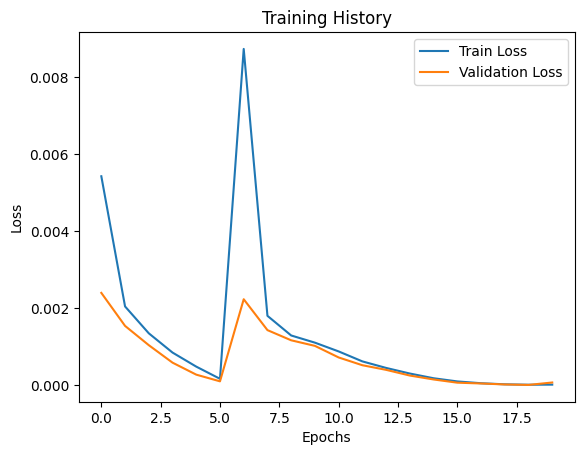

In [276]:
# Plot the training history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [277]:
# Calculate MSE for the validation dataset
x_out_val = autoencoder.predict(x_val_normal)
mse_val = np.mean(np.square(x_val_normal - x_out_val))

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
(10, 720)
(1188, 720)
(1188, 720)


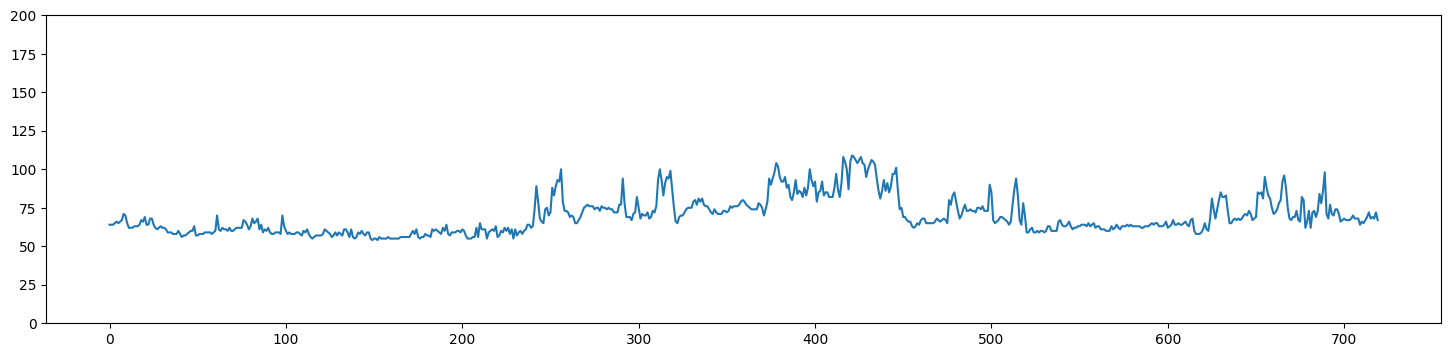

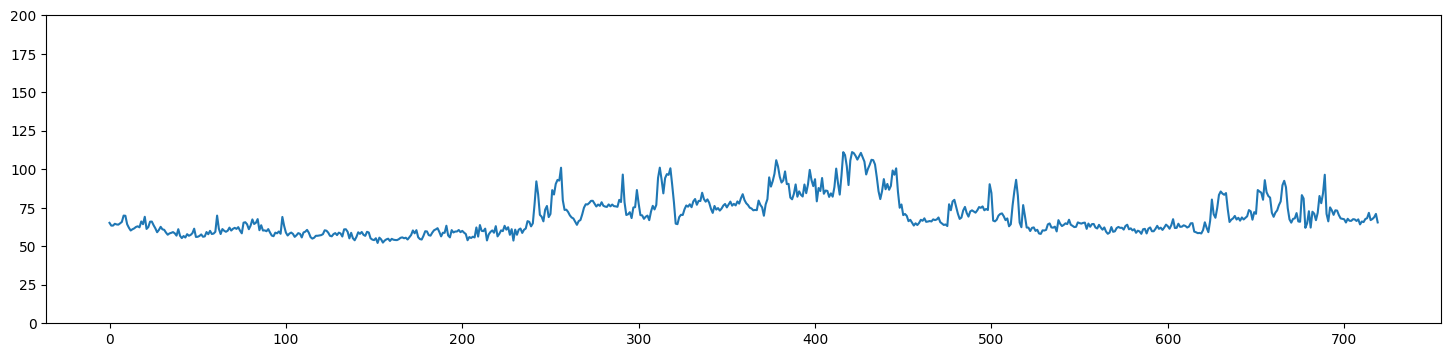

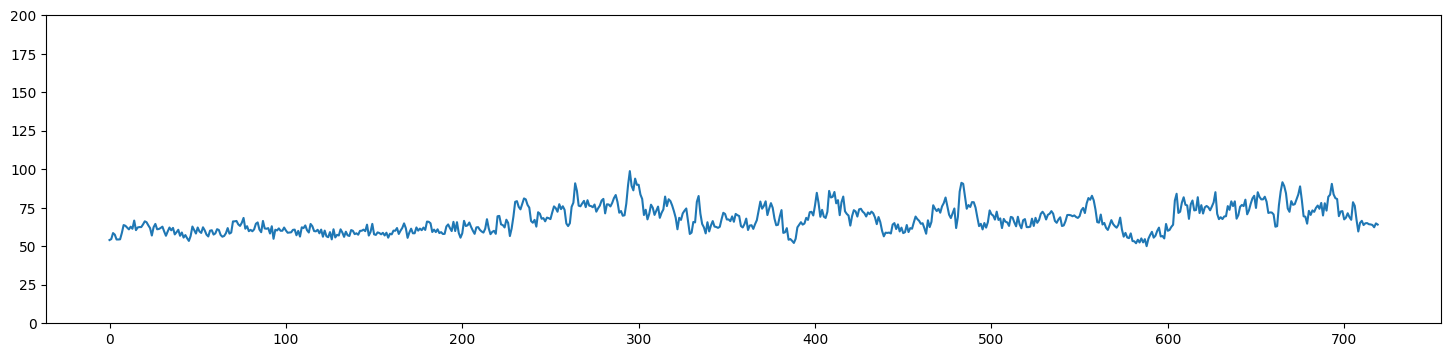

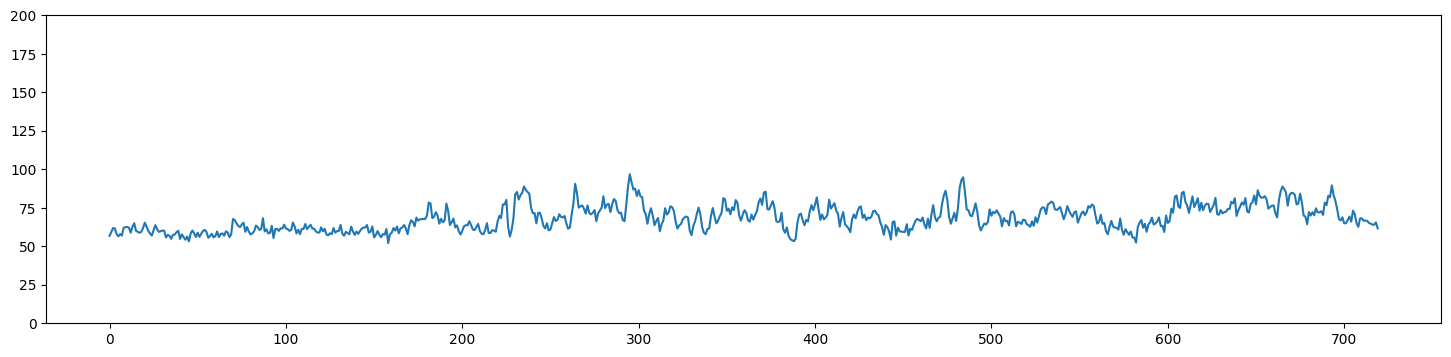

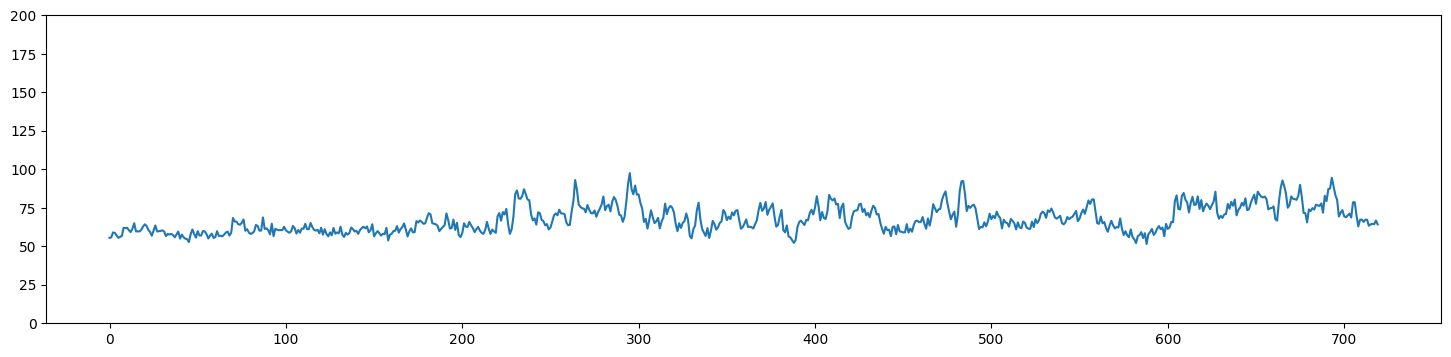

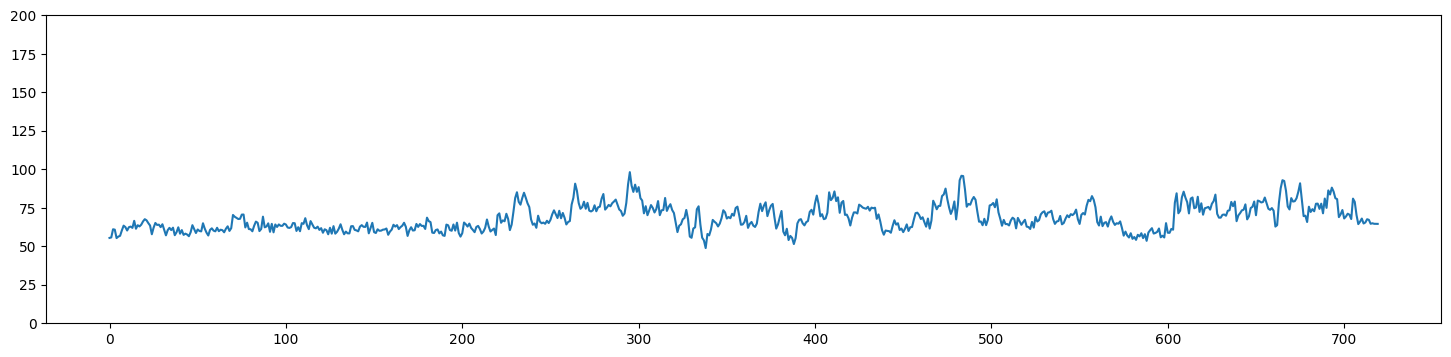

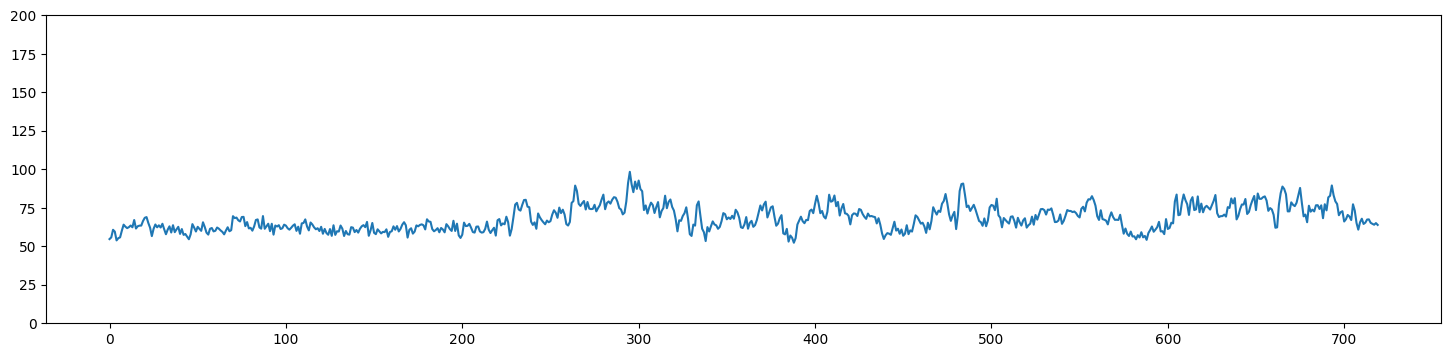

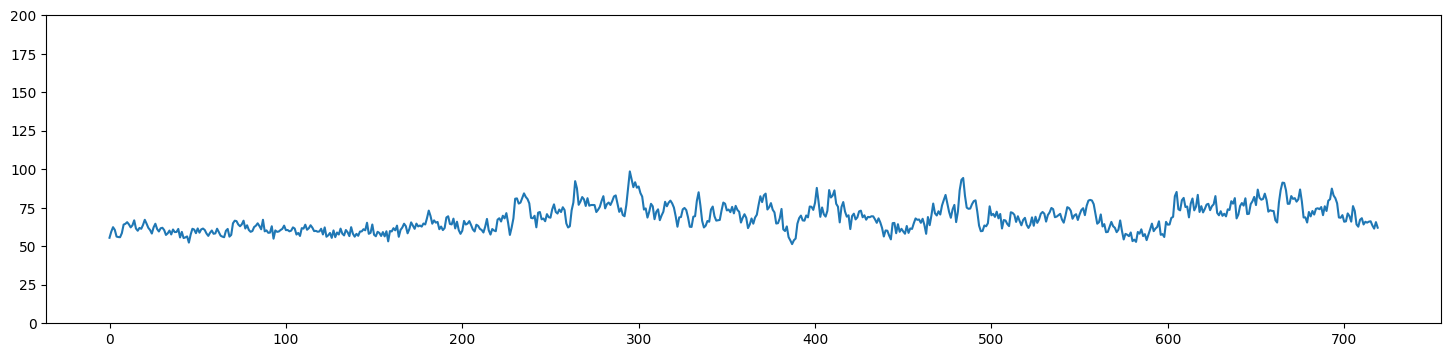

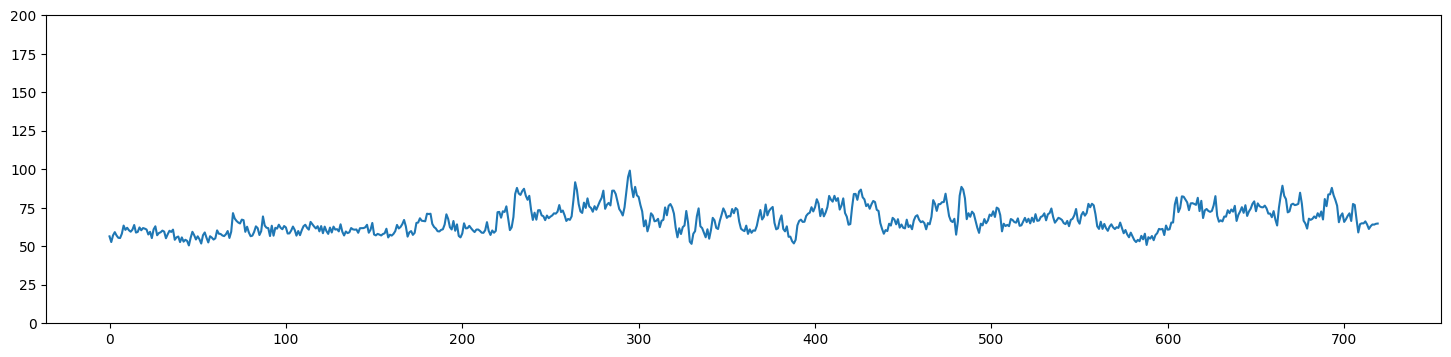

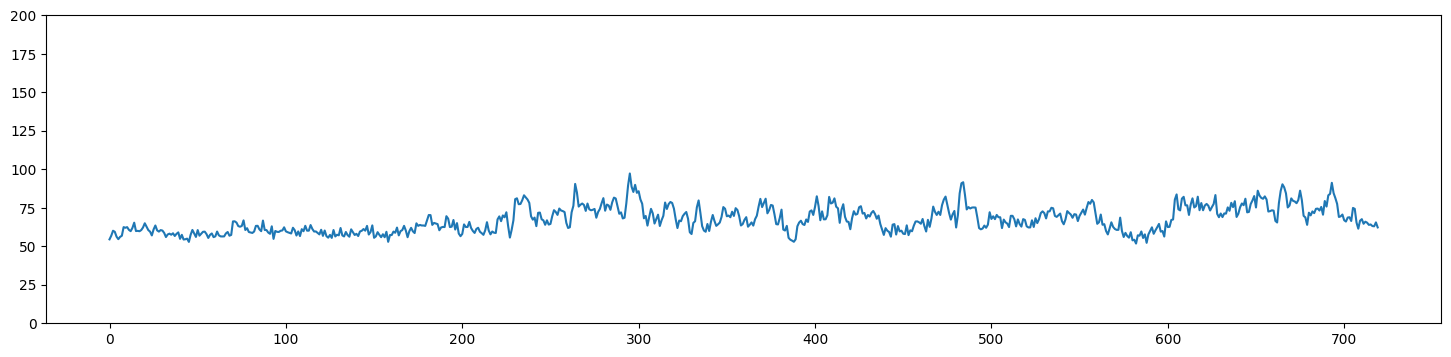

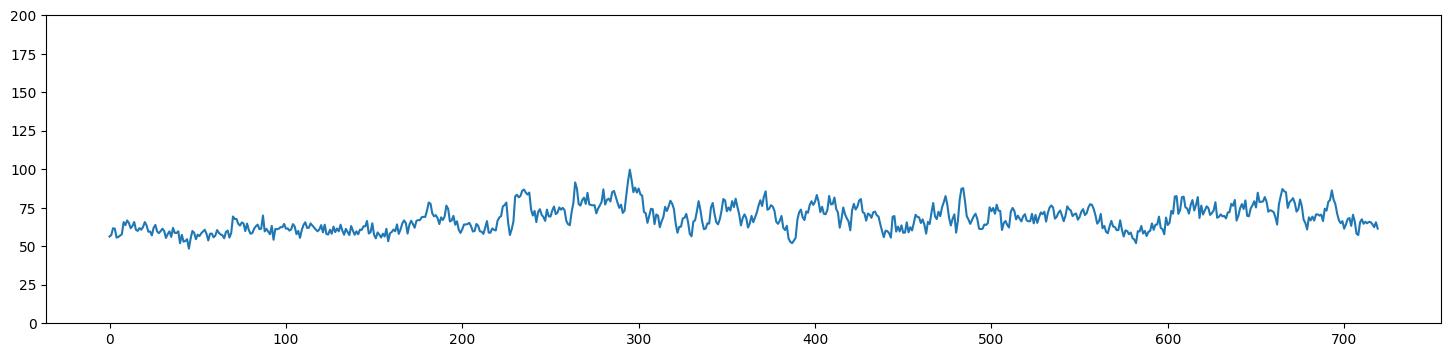

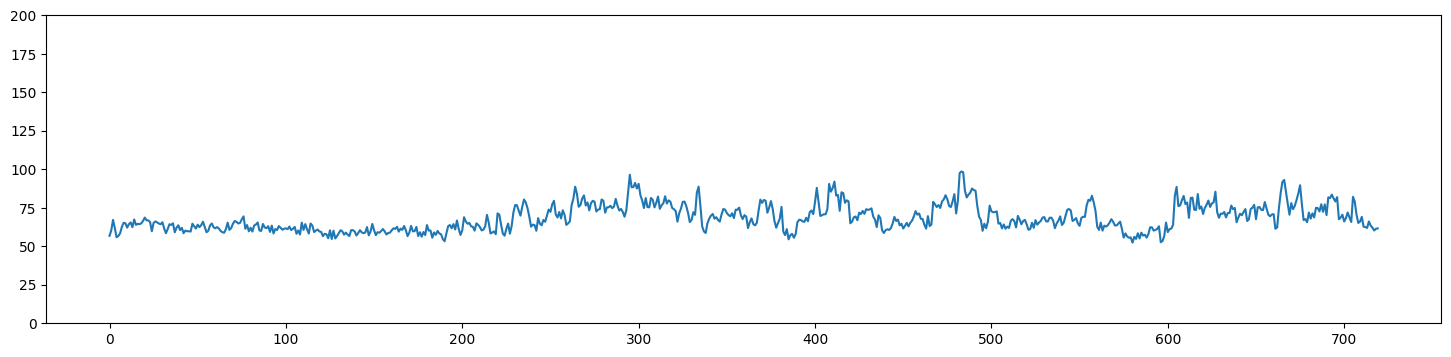

In [ ]:
newrandow = np.random.normal(loc=x_train_normal.mean(), scale=x_train_normal.std(),size=(10, 720))
newrandow = autoencoder.predict(newrandow)

print(newrandow.shape)
print(x_val_normal.shape)
print(x_out_val.shape)

plot_hr(x_val_normal[1]*250)
plot_hr(x_out_val[1]*250)

for i in range(10):
    plot_hr(newrandow[i]*250)